In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### 동영상 gif로 변환하는 함수

In [2]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save('movie_cartpole.mp4')
    #display(display_animation(anim, default_mode='loop'))

## CartPole Q러닝 구현

#### 상수

In [3]:
ENV = 'CartPole-v0'
NUM_DIZITED = 6
GAMMA = 0.99
ETA = 0.5
MAX_STEPS = 200
NUM_EPISODES = 1000

### Agent 구현

In [4]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_Q_function(self, observation, action, reward, observation_next):
        self.brain.update_Q_table(observation, action, reward, observation_next)
        
    def get_action(self, observation, step):
        action = self.brain.decide_action(observation, step)
        return action

### Brain 구현

In [5]:
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITED**num_states, num_actions))
        
    # 이산값으로 만들 구간 계산
    # 상태는 각 변수 당 총 6가지의 구간으로 나눔
    def bins(self, clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
    
    # 이산값으로 변환 후 6진수로 변환
    def digitize_state(self, observation):
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITED))
        ]

        return sum([x * (NUM_DIZITED**idx) for idx, x in enumerate(digitized)])
    
    def update_Q_table(self, observation, action, reward, observation_next):
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
                                      ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
        
    def decide_action(self, observation, episode):
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)
        
        return action

### Environment 구현

In [6]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n
        self.agent = Agent(num_states, num_actions)
        
    def run(self):
        complete_episodes = 0
        is_episode_final = False
        frames = []
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset()
            
            for step in range(MAX_STEPS):
                if is_episode_final:
                    frames.append(self.env.render(mode='rgb_array'))
                action = self.agent.get_action(observation, episode)
                observation_next, _, done, _ = self.env.step(action)
                
                if done:
                    if step < 195:
                        reward = -1
                        complete_episodes = 0
                    else:
                        reward = 1
                        complete_episodes += 1
                else:
                    reward = 0
                    
                self.agent.update_Q_function(observation, action, reward, observation_next)
                
                observation = observation_next
                
                if done:
                    print("{} Episode: finished after {} steps".format(episode, step + 1))
                    break
                
            if is_episode_final:
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:
                print('10 Sequential Episodes Success')
                is_episode_final = True

## CartPole 학습 구현

0 Episode: finished after 13 steps
1 Episode: finished after 23 steps
2 Episode: finished after 13 steps
3 Episode: finished after 67 steps
4 Episode: finished after 26 steps
5 Episode: finished after 19 steps
6 Episode: finished after 23 steps
7 Episode: finished after 72 steps
8 Episode: finished after 9 steps
9 Episode: finished after 10 steps
10 Episode: finished after 11 steps
11 Episode: finished after 13 steps
12 Episode: finished after 59 steps
13 Episode: finished after 11 steps
14 Episode: finished after 41 steps
15 Episode: finished after 12 steps
16 Episode: finished after 13 steps
17 Episode: finished after 10 steps
18 Episode: finished after 85 steps
19 Episode: finished after 10 steps
20 Episode: finished after 13 steps
21 Episode: finished after 14 steps
22 Episode: finished after 94 steps
23 Episode: finished after 14 steps
24 Episode: finished after 24 steps
25 Episode: finished after 128 steps
26 Episode: finished after 73 steps
27 Episode: finished after 107 steps
2

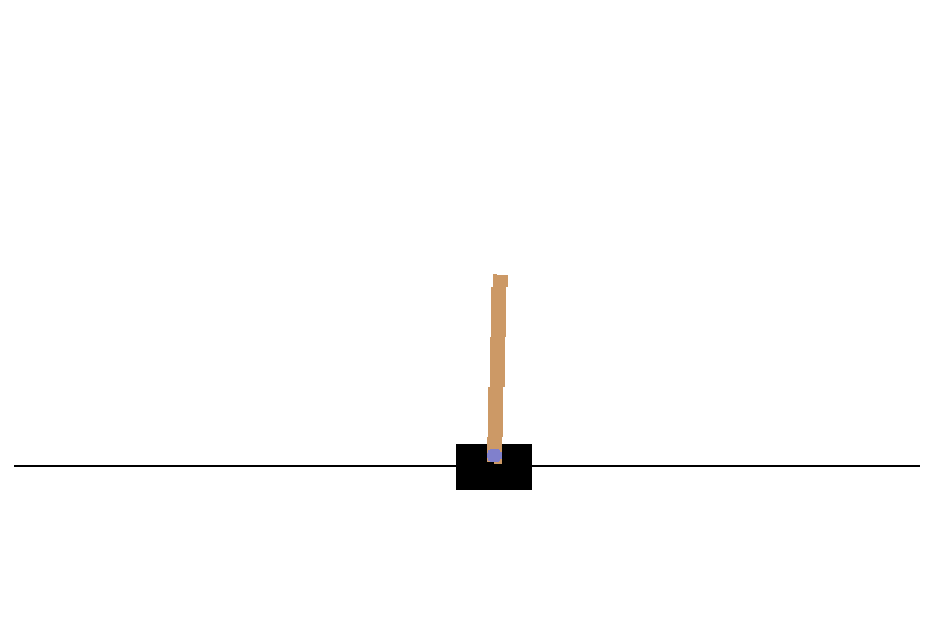

In [7]:
cartpole_env = Environment()
cartpole_env.run()

In [5]:
import ffmpy
ff = ffmpy.FFmpeg(
    inputs = {"movie_cartpole.mp4" : None},
    outputs = {"movie_cartpole.gif" : None})
 
ff.run()

(None, None)